In [178]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [179]:
class CustomLDA:
    def __init__(self, class_weight_ratio=1.0):
        self.W = None
        self.B = None
        self.class_weight_ratio = class_weight_ratio

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # 均值向量
        mean_class1 = np.mean(X[y == 1], axis=0)
        mean_class2 = np.mean(X[y == 2], axis=0)

        # 矩陣
        S1 = np.dot((X[y == 1] - mean_class1).T, X[y == 1] - mean_class1)
        S2 = np.dot((X[y == 2] - mean_class2).T, X[y == 2] - mean_class2)
        
        # 權重
        S1 *= self.class_weight_ratio
        within_class_scatter = S1 + S2
        self.W = np.dot(np.linalg.inv(within_class_scatter), (mean_class1 - mean_class2))

        self.B = -0.5 * np.dot(mean_class1, np.dot(np.linalg.inv(within_class_scatter), mean_class1)) + 0.5 * np.dot(mean_class2, np.dot(np.linalg.inv(within_class_scatter), mean_class2))

    def predict(self, X):
        if self.W is None or self.B is None:
            raise ValueError("The model has not been trained yet.")
        scores = np.dot(X, self.W) + self.B
        predictions = np.where(scores >= 0, 1, 2)
        return predictions

    def get_weights(self):
        return self.W

    def get_bias(self):
        return self.B

In [180]:
data_head = pd.read_csv('iris_head_23.txt', delim_whitespace=True)
data_tail = pd.read_csv('iris_tail_23.txt', delim_whitespace=True)

# 將標籤值3替換為1
data_head['species'] = data_head['species'].replace({2: 2, 3: 1})
data_tail['species'] = data_tail['species'].replace({2: 2, 3: 1})

y_head = data_head['species'].values
y_tail = data_tail['species'].values

columns_to_drop = ["species"]

x_head = data_head.drop(columns_to_drop, axis=1).values
x_tail = data_tail.drop(columns_to_drop, axis=1).values

In [181]:
# LDA分類器
lda_classifier = CustomLDA(class_weight_ratio=1)
lda_classifier.fit(x_head, y_head)
predictions = lda_classifier.predict(x_tail)

# 分類率
classification_rate = np.mean(predictions == y_head) * 100

# w and b
weights = lda_classifier.get_weights()
bias = lda_classifier.get_bias()

print(f"分類率: {classification_rate:.2f}%")
print(f"權重 (weights): {weights}")
print(f"偏差 (bias): {bias}")

分類率: 94.00%
權重 (weights): [-0.1034507  -0.13529314  0.16974041  0.30764244]
偏差 (bias): -0.32879987003848044


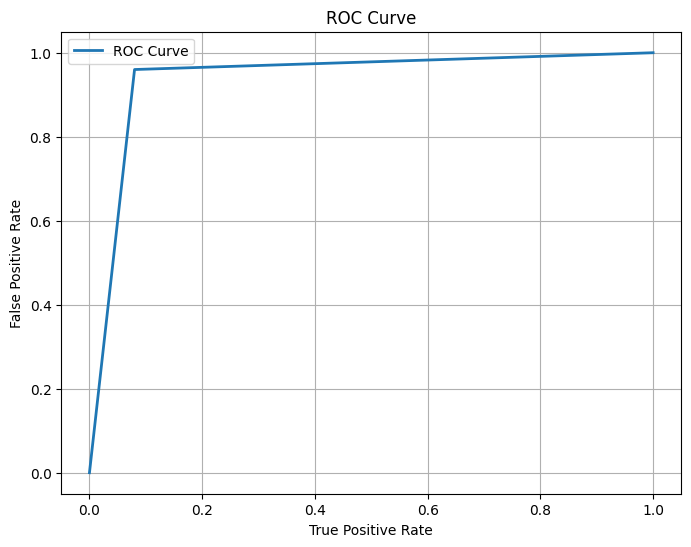

AUC: 0.9400000000000001


In [183]:
from sklearn.metrics import roc_curve, roc_auc_score

predictions = lda_classifier.predict(x_tail)

# ROC
fpr, tpr, thresholds = roc_curve(y_tail, predictions, pos_label=1)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(tpr, fpr, linewidth=2, label='ROC Curve')
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

auc = roc_auc_score(y_head, predictions)
print('AUC:', auc)
